In [66]:
import cv2
import os
from datetime import datetime
import time
import csv
import numpy as np
import onnxruntime as ort
from ultralytics import YOLO
from ultralytics.utils import LOGGER
import joblib
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt

from skimage.exposure import match_histograms

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mtcnn = MTCNN(keep_all=True, device=device)
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)
classifier = joblib.load("models/face_classifier.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

In [68]:
yolo_model = YOLO("models/yolov8n.pt")
session = ort.InferenceSession("models/public/anti-spoof-mn3/anti-spoof-mn3.onnx")

In [69]:
img_class = cv2.imread('dataset/anti-spoof/real/z6445249434007_c56ce8ff4e14289af962cd6542f03aa0.jpg', cv2.IMREAD_UNCHANGED)
img_cf = cv2.imread('Student_Attendance_Image/2025-03-26/HE190303/22-25-34.jpg', cv2.IMREAD_UNCHANGED)

img_class_rgb = cv2.cvtColor(img_class, cv2.COLOR_BGR2RGB)
img_cf_rgb = cv2.cvtColor(img_cf, cv2.COLOR_BGR2RGB)

(-0.5, 639.5, 479.5, -0.5)

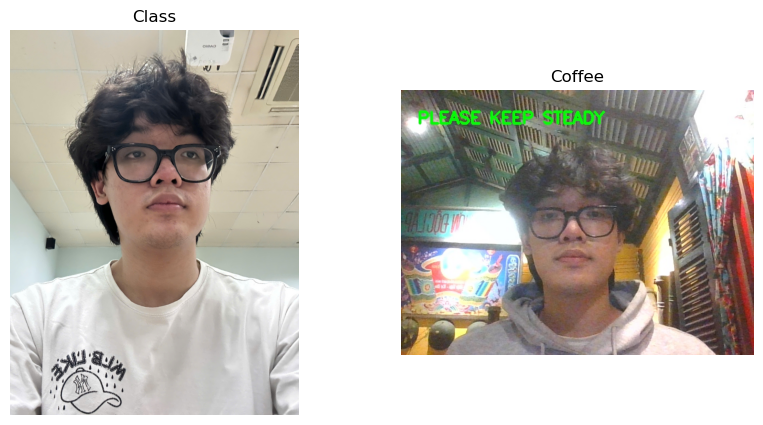

In [70]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_class_rgb)
plt.title("Class")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_cf_rgb)
plt.title("Coffee")
plt.axis('off')

In [71]:
def frame_processing(img, to_rgb=True):
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)/255.0
    img = np.expand_dims(img, axis = 0)
    return img

In [72]:
img_class_ = frame_processing(img_class)
input_name = session.get_inputs()[0].name
output = session.run(None, {input_name: img_class_})[0]  # Run inference
output

array([[    0.32793,     0.67207]], dtype=float32)

In [73]:
img_cf_ = frame_processing(img_cf)
input_name = session.get_inputs()[0].name
output = session.run(None, {input_name: img_cf_})[0]  # Run inference
output

array([[    0.73587,     0.26413]], dtype=float32)

In [74]:
def match_brightness(image, reference):
    """ Điều chỉnh độ sáng của ảnh đầu vào sao cho giống với ảnh tham chiếu """
    # Chuyển ảnh về grayscale để tính độ sáng
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ref_gray = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

    # Tính độ sáng trung bình
    current_brightness = np.mean(gray)
    target_brightness = np.mean(ref_gray)

    # Điều chỉnh độ sáng bằng hệ số scale
    scale = target_brightness / (current_brightness + 1e-5)  # Tránh chia cho 0
    adjusted = np.clip(image * scale, 0, 255).astype(np.uint8)

    return adjusted


brightness_adjusted = match_brightness(img_class, img_cf)

brightness_adjusted = cv2.cvtColor(brightness_adjusted, cv2.COLOR_BGR2RGB)

(-0.5, 1919.5, 2559.5, -0.5)

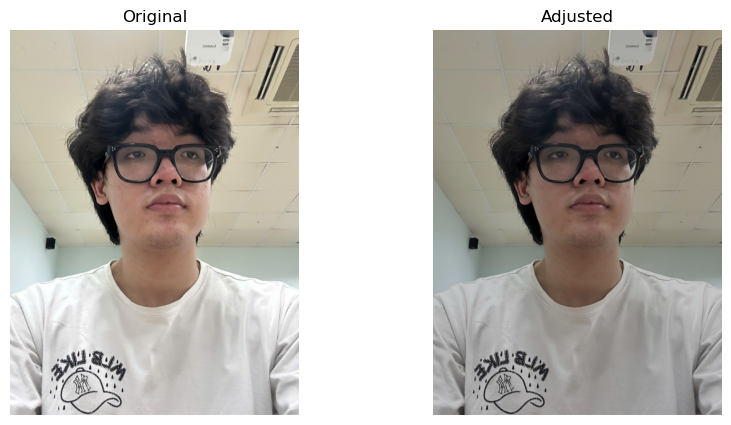

In [75]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_class_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(brightness_adjusted)
plt.title("Adjusted")
plt.axis('off')

In [76]:
def match_histogram(image, reference):
    """ Điều chỉnh histogram của ảnh sao cho giống với ảnh tham chiếu """
    matched = match_histograms(image, reference, channel_axis=-1)
    return matched

# Áp dụng Histogram Matching
final_adjusted = match_histogram(brightness_adjusted, img_cf)

(-0.5, 1919.5, 2559.5, -0.5)

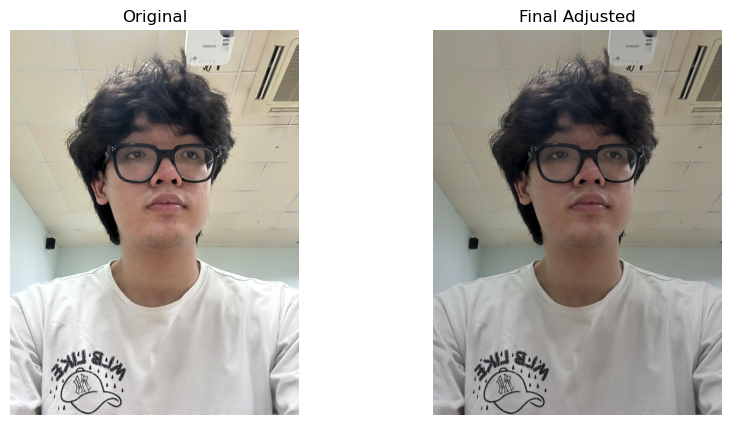

In [77]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_class_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(brightness_adjusted)
plt.title("Final Adjusted")
plt.axis('off')

In [78]:
img_class_adjust = frame_processing(final_adjusted)
input_name = session.get_inputs()[0].name
output = session.run(None, {input_name: img_class_adjust})[0]  # Run inference
output

array([[    0.42202,     0.57798]], dtype=float32)